In [7]:
import numpy as np
import matplotlib.pyplot as plt

from galpy.util import bovy_coords, bovy_plot
from galpy.potential import MWPotential2014, HernquistPotential, NFWPotential, vcirc, turn_physical_off
from galpy.util.bovy_conversion import dens_in_msolpc3, mass_in_msol,mass_in_1010msol
from galpy.orbit import Orbit

import astropy.units as apu

from scipy.integrate import quad
from galpy.util import bovy_conversion

from gaia_tools import query

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


## Calculate basic structural parameters of the model

### Calculate the concentration

10.89523657918724 3.460564778674822
The halo concentration with respect to critical density is:  10.09882132726553
The scale factor of the disk should be:  27.68


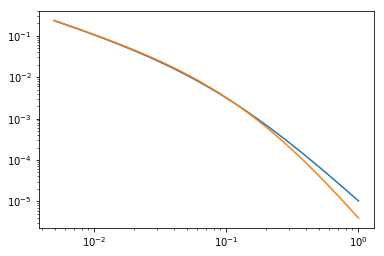

In [35]:
mwp= [MWPotential2014[0],MWPotential2014[1],MWPotential2014[2]*1.5]

c= mwp[2].conc(H=100,wrtcrit=True)
r200= mwp[2].rvir(H=100,wrtcrit=True)
M200= mwp[2].mvir(H=100,wrtcrit=True)
a= r200/c*np.sqrt(2.*(np.log(1+c)-c/(1+c)))

print(M200, a)

Rspace= np.geomspace(0.1,r200,101)
MWhdens= [mwp[2].dens(r,0.)*dens_in_msolpc3(220.,8.) for r in Rspace]

hern= HernquistPotential(amp=M200*2.,a=a)
hern.turn_physical_off()
Hernhdens= np.array([hern.dens(r,0.)*dens_in_msolpc3(220.,8.) for r in Rspace])

plt.plot(Rspace/r200,MWhdens)
plt.plot(Rspace/r200,Hernhdens)
plt.yscale('log')
plt.xscale('log')

print('The halo concentration with respect to critical density is: ', c)
# Use this to calculate the actual conncentration
print('The scale factor of the disk should be: ', np.round(a*8.,2))

In [244]:
MTot= M200+mwp[0].mass(r200)+mwp[1].mass(r200,z=r200)

nfw= NFWPotential(H=100,conc=c,mvir= MTot*mass_in_1010msol(220.,8.)/100.,wrtcrit=True )
v200= nfw.vcirc(nfw.rvir(H=100,wrtcrit=True))*220.

print('The circular velocity at the virial radius (wrt critical density) is: ',
      np.round(v200,1))

c= 10.4295

The circular velocity at the virial radius (wrt critical density) is:  165.4


### Calculate the spin parameter of the model

In [251]:
def Jdintegrand(R,pot):
    vc= vcirc(pot,R)
    sd= pot[1].surfdens(R,1.)
    return 2.*np.pi*R**2*vc*sd

Jd= quad(lambda x: Jdintegrand(x,mwp), 0., np.inf)[0]
Jd= Jd*mwp[1].mass(R=r200,z=r200)

md= mwp[1].mass(R=r200,z=r200)/MTot

fc= c*(1-1/(1+c)**2-2*np.log(1+c)/(1+c))/2./(np.log(1+c)-c/(1+c))**2
print(fc)
G= 4.3009*1e-3*(1./8000.)*(bovy_conversion.mass_in_msol(220.,8.))*(1./220.)**2.

ll= Jd/md/G**0.5/M200**1.5/r200**0.5*(fc/2)**2

print('The spin parameter is: ',ll)
print('By definition the disc spin fraction is equal to "md": ', np.round(md,4))

1.2714253977621035
The spin parameter is:  0.047853250206865
By definition the disc spin fraction is equal to "md":  0.0636


### Calculate the bulge and disc mass fraction

In [246]:
mb= mwp[0].mass(r200)/MTot
md= mwp[1].mass(R=r200,z=r200)/MTot
print('The bulge mass fraction, mb, is: ',mb)
print('The disc mass fraction, md, is: ',md)

The bulge mass fraction, mb, is:  0.004277653130308517
The disc mass fraction, md, is:  0.06360149357793536


### Calculate thickess of the stellar disc

Should maybe check the vertical and radial profile comparison between MWPotential and exponential disc

The thickness of stellar disk in units of radial scale length is:  0.0933
0.047853250206865


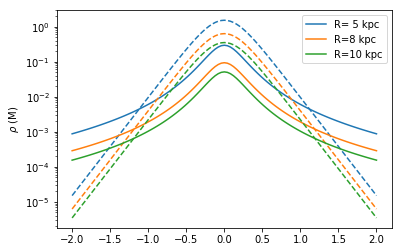

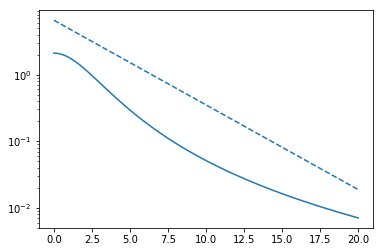

In [291]:
abratio= MWPotential2014[1]._b/MWPotential2014[1]._a
print('The thickness of stellar disk in units of radial scale length is: ',
      np.round(abratio,4))
print(ll)
turn_physical_off(mwp)

H = 3.41
Z0 = 0.31

#z0= 0.31 #MWPotential2014[1]._b*8.
#h= 3.41 #MWPotential2014[1]._a*8.

def p_disc(R,z,z0,h):
    amp= mwp[1].mass(r200)*10**10/4./np.pi/(1000.*z0)/(1000.*h)**2
    return amp*1/np.cosh(z/z0)**2*np.exp(-R/h)

z= np.linspace(-2,2,101)

dens5= np.array([mwp[1].dens(5./8.,zz/8.) for zz in z])*dens_in_msolpc3(220.,8.)
dens8= np.array([mwp[1].dens(8./8.,zz/8.) for zz in z])*dens_in_msolpc3(220.,8.)
dens10= np.array([mwp[1].dens(10./8.,zz/8.) for zz in z])*dens_in_msolpc3(220.,8.)

plt.plot(z,dens5,c='C0',label=r'R= 5 kpc')
plt.plot(z,p_disc(5.,z,Z0,H),c='C0',ls='--')
plt.plot(z,dens8,c='C1',label=r'R=8 kpc')
plt.plot(z,p_disc(8.,z,Z0,H),c='C1',ls='--')
plt.plot(z,dens10,c='C2',label=r'R=10 kpc')
plt.plot(z,p_disc(10.,z,Z0,H),c='C2',ls='--')
plt.yscale('log')

plt.ylabel(r'$\rho \mathrm{\,\,(M)}$')
plt.legend()


R= np.linspace(0.01,20,101)

densR= np.array([mwp[1].dens(r/8.,0.) for r in R])

plt.figure()
plt.plot(R,densR*dens_in_msolpc3(220.,8.),c='C0',label=r'R= 5 kpc')
plt.plot(R,p_disc(R,0.,Z0,H),c='C0',ls='--')
plt.yscale('log')

### Calculate Bulge scale length

Mass of MWPotential2014 bulge is:  0.05 
 and the hernquist mass is:  0.05
Circular velocity of MWPotential2014 bulge at r200 is:  0.05 
 and the hernquist circular velocity at r200 is:  0.05

 The bulge size in units of halo scale length is:  0.019361001537343502
0.536


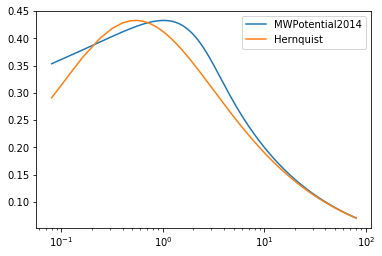

In [211]:
rrange= np.linspace(0.01,10.01,1001)
Hern= HernquistPotential(amp=0.1005, a=0.067)

plt.plot(rrange*8.,mwp[0].vcirc(rrange),label='MWPotential2014')
plt.plot(rrange*8.,Hern.vcirc(rrange),label='Hernquist')
plt.xscale('log')
plt.legend()

print('Mass of MWPotential2014 bulge is: ',np.round(mwp[0].mass(r200),3),
      '\n and the hernquist mass is: ',np.round(Hern.mass(r200),3))
print('Circular velocity of MWPotential2014 bulge at r200 is: ',np.round(mwp[0].vcirc(r200),3),
      '\n and the hernquist circular velocity at r200 is: ',np.round(Hern.vcirc(r200),3))

print('\n The bulge size in units of halo scale length is: ',np.round(Hern.a/a,4))

print(Hern.a*8.)

## Selection of symmetry constraints of velocity structure

### Calculate $v_R/v_z$ using Gaia data

In [18]:
velquery= '''SELECT radial_velocity, radial_velocity_error, phot_g_mean_mag, bp_rp,
ra, dec, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error
FROM gaiadr2.gaia_source
WHERE radial_velocity IS NOT Null AND parallax_over_error>5.
AND parallax IS NOT Null'''

out= query.query(velquery,local=False)
query.cache.nickname(velquery,'velq')

True

The disc dispersion of $v_R$ over $v_Z$ ratio is:  1.874


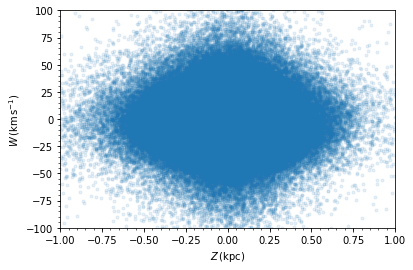

In [149]:
test= np.vstack([np.array(out['ra']),np.array(out['dec']),np.array(1./out['parallax']),
                  np.array(out['pmra']), np.array(out['pmdec']),np.array(out['radial_velocity'])]).T
test[0]*= apu.deg
test[1]*= apu.deg
test[2]*= apu.kpc
test[3]*= apu.mas/apu.yr
test[4]*= apu.mas/apu.yr
test[5]*= apu.km/apu.s

o= Orbit(vxvv=test,radec=True,solarmotion='schoenrich',zo=0.0208*apu.kpc,ro=8.124*apu.kpc)

mask= (np.sqrt((o.x()-8.124)**2+o.y()**2) < .25)

bovy_plot.bovy_plot(o.z()[mask],o.vz()[mask],'.',alpha=0.1,
                   xrange=[-1.,1.],
                   yrange=[-100.,100.],
                   xlabel=r'$Z\,(\mathrm{kpc})$',
                   ylabel=r'$W\,(\mathrm{km\,s}^{-1})$') 

vzstd= np.std(o.vz()[mask])
vrstd= np.std(o.vR()[mask])

vrvz= vrstd/vzstd
print(r'The disc dispersion of $v_R$ over $v_Z$ ratio is: ', np.round(vrvz,3))

In [192]:
k2= np.mean(o.vphi())**2/(np.mean(o.vphi()**2)-vrstd**2)
print(r'The mean streaming parameter in the local neighbourhood is: ', np.round(np.sqrt(k2),3))

The mean streaming parameter in the local neighbourhood is:  0.985


## Calculate Sgr Parameters

In [83]:
from astropy.constants import G
H= 100.*apu.km/apu.s/apu.Mpc

sgrM200= (1.e10+2.e8)*apu.Msun
sgrV200= ((10.*H*G*sgrM200)**(1./3.)).to(apu.km/apu.s)
sgrR200= (sgrV200/10./H).to(apu.kpc)

In [84]:
print(sgrM200,sgrV200,sgrR200)

10200000000.0 solMass 35.268507935383674 km / s 35.26850793538368 kpc


In [85]:
c= 25.2447
a= sgrR200/c*np.sqrt(2.*(np.log(1+c)-c/(1+c)))
print(a)

2.9999964712035077 kpc


In [86]:
2e8/1e10

0.02

In [87]:
0.65/3.

0.21666666666666667

In [88]:
1e10/1e12*3e7

300000.0

In [90]:
2e8/1e10*300000

6000.0